# Обучение модели

Работа с данными и обучение модели отделены друг от друга. Это нормальное решение, связанное с, даже, визуальной переполненностью пространства анализа и пространства проектирования модели.

В качестве инструмента для обучения будет использовать модель CatBoost, разработанная специалистами компании Яндекс. Эта модель имеет много положительных качеств, но главное, конечно, в среднем наилучашая достигаемая точность среди моделей бустинга.

В качестве данны в данном ноутбуке необходимо использовать данные, полученные на этапе преобразования и обработки данных. Данные должны содержать дискрипторы и значение искомой величины.

In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix

from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor, Pool, cv, CatBoostClassifier

In [4]:
df = pd.read_excel("/content/data.xlsx")
df = df.drop(columns = ['Unnamed: 0'],axis = 1)

In [ ]:
df_test = pd.read_excel("/content/data_test.xlsx")
df_test = df_test.drop(columns = ['Unnamed: 0'],axis = 1)

В качестве решаемой задачи попробуем решить не задачу регрессии, а задачу классификаци на два класса. При этом у нас возникает ключевая проблема в задаче - как разделять объекты на два класса?

## Пробный код

Прежде, чем писать полный рабочий код, попробуем реализовать одну итреацию, которая состоит в том, что значения разделителя мы установим равным пяти.

In [6]:
bins = [-np.inf, 5, np.inf]
labels = [0, 1]
df['IC50_cl'] = pd.cut(df['IC50'], bins=bins, labels=labels)

In [ ]:
df.columns

Index(['Title', 'IC50, mmg/ml', 'CC50-MDCK, mmg/ml', 'SI', 'Molecular weight',
       'Hydrogen bond acceptors', 'Hydrogen bond donors', 'Polar SA', 'SMILES',
       'Pictures', 'HeavyAtomCount', 'NHOHCount', 'NOCount', 'NumHAcceptors',
       'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
       'NumValenceElectrons', 'NumAromaticRings', 'NumAliphaticHeterocycles',
       'RingCount', 'MW', 'LogP', 'MR', 'TPSA', 'IC50_classif'],
      dtype='object')

In [8]:
df['IC50_cl'].value_counts()

0    24862
1    11515
Name: IC50_cl, dtype: int64

In [10]:
df_classif = df[['HeavyAtomCount', 'NHOHCount', 'NOCount', 'NumHAcceptors',
       'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
       'NumValenceElectrons', 'NumAromaticRings', 'NumAliphaticHeterocycles',
       'RingCount', 'MW', 'LogP', 'MR', 'TPSA', 'IC50_cl']]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_classif.drop(columns = ['IC50_cl'],axis = 1), df_classif['IC50_cl'], test_size=0.33, random_state=42)

In [12]:
model = CatBoostClassifier(iterations=1000)
model.fit(X_train,
          y_train, verbose = 100)

Learning rate set to 0.040284
0:	learn: 0.6835891	total: 62.7ms	remaining: 1m 2s
100:	learn: 0.5605197	total: 1.91s	remaining: 17s
200:	learn: 0.5507889	total: 3.02s	remaining: 12s
300:	learn: 0.5416150	total: 3.81s	remaining: 8.86s
400:	learn: 0.5315829	total: 4.61s	remaining: 6.89s
500:	learn: 0.5226980	total: 5.44s	remaining: 5.42s
600:	learn: 0.5147275	total: 6.25s	remaining: 4.15s
700:	learn: 0.5076207	total: 7.06s	remaining: 3.01s
800:	learn: 0.5011495	total: 7.86s	remaining: 1.95s
900:	learn: 0.4951260	total: 8.65s	remaining: 951ms
999:	learn: 0.4889753	total: 9.47s	remaining: 0us


In [13]:
preds_class = model.predict(X_test)

In [14]:
cm = confusion_matrix(y_test, preds_class)

cm

array([[7474,  682],
       [2800, 1049]])

In [15]:
TN, FP, FN, TP = confusion_matrix(y_test, preds_class).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

True Positive(TP)  =  1049
False Positive(FP) =  682
True Negative(TN)  =  7474
False Negative(FN) =  2800


In [16]:
accuracy =  (TP + TN) / (TP + FP + TN + FN)

print('Accuracy of the binary classifier = {:0.3f}'.format(accuracy))

Accuracy of the binary classifier = 0.710


## Метод

Теперь попробуем перебрать разные значения разделителя и посмотрим, что в итоге будет получаться.

In [17]:
def com():
    df = pd.read_excel("/content/data.xlsx")
    df = df.drop(columns = ['Unnamed: 0'],axis = 1)

    res = {}
    for p in [1, 3, 5, 8, 10, 15, 20, 22, 30, 50, 100, 150, 200, 300, 400]:
        print(f'p == {p}')

        df['IC50_classif'] = pd.cut(df['IC50'], bins=[-np.inf, p, np.inf], labels=[0, 1])

        df_classif = df[['HeavyAtomCount', 'NHOHCount', 'NOCount', 'NumHAcceptors',
       'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
       'NumValenceElectrons', 'NumAromaticRings', 'NumAliphaticHeterocycles',
       'RingCount', 'MW', 'LogP', 'MR', 'TPSA', 'IC50_classif']]

        X_train, X_test, y_train, y_test = train_test_split(df_classif.drop(columns = ['IC50_classif'],axis = 1), df_classif['IC50_classif'], test_size=0.33, random_state=42)

        model = CatBoostClassifier(iterations=1000)
        model.fit(X_train, y_train, verbose = 100)
        preds_class = model.predict(X_test)

        cm = confusion_matrix(y_test, preds_class)
        TN, FP, FN, TP = confusion_matrix(y_test, preds_class).ravel()
        accuracy =  (TP + TN) / (TP + FP + TN + FN)

        print('Accuracy of the binary classifier = {:0.3f}'.format(accuracy))
        print('---')
        print(' ')

        res[p] = accuracy

    return res

In [18]:
resIC50 = com()

p == 1
Learning rate set to 0.040284
0:	learn: 0.6689440	total: 8.69ms	remaining: 8.68s
100:	learn: 0.4036309	total: 803ms	remaining: 7.15s
200:	learn: 0.3937659	total: 1.59s	remaining: 6.32s
300:	learn: 0.3851528	total: 2.39s	remaining: 5.54s
400:	learn: 0.3768681	total: 3.2s	remaining: 4.78s
500:	learn: 0.3692315	total: 4s	remaining: 3.99s
600:	learn: 0.3621462	total: 4.82s	remaining: 3.2s
700:	learn: 0.3559713	total: 5.59s	remaining: 2.39s
800:	learn: 0.3498672	total: 6.4s	remaining: 1.59s
900:	learn: 0.3440189	total: 7.2s	remaining: 791ms
999:	learn: 0.3389013	total: 7.99s	remaining: 0us
Accuracy of the binary classifier = 0.844
---
 
p == 3
Learning rate set to 0.040284
0:	learn: 0.6873139	total: 8.01ms	remaining: 8s
100:	learn: 0.6008750	total: 816ms	remaining: 7.26s
200:	learn: 0.5915711	total: 2.04s	remaining: 8.11s
300:	learn: 0.5826525	total: 3.6s	remaining: 8.37s
400:	learn: 0.5724314	total: 5.12s	remaining: 7.65s
500:	learn: 0.5629272	total: 5.92s	remaining: 5.9s
600:	learn

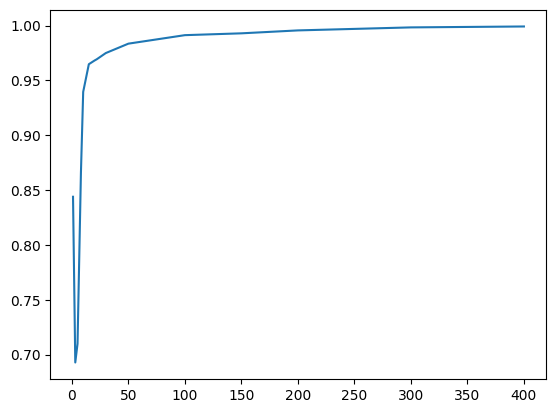

In [19]:
plt.plot(resIC50.keys(), resIC50.values())

# Выводы

В данном случае всё зависит только и исключительно от того, какой порог будет установлен для разделения данных. Это можно и нужно было понять при анализе данных, на этапе их преобразования и обработки.